1 Prepração do notebook
2 Obtenção dos dados, tratamento e geração de Data Frames

* Dados sobre Covid
    * Obtenção de dados do COVID19 e geração do Data Frame df_covid19_br
    * Geração do df_covid19_br_para_shapefile com tratamento dos dados
    * Geração do Geo Data Frames gdf_covid19_br, com os casos para o Brasil, e gdf_covid19_pr, com os casos do Paraná
* Obtenção dos Demais dados
* nível de hierarquia urbana
* população
* mobilidade pendular
* níveis de exportação
* pib percapita
* número de pessoas com renda elevada (a definir o critério)
* tentar identificar uma forma de criar uma base que se atualize dinamicamente e identifique avizinhamento de municípios 0 e 1 

3 Análise Exploratória Correlações

* Gerar painel de estatística descritiva

* Gerar gráficos de distribuição
* Fazer matriz de correlações

4 Modelização

# Obtenção e tratamento dos dados sobre COVID-19 no Brasil

Esse notebook visa a:

* obtenção de dados sobre covid-19
* importação desses dados em estruturas de data frame para tratamento e análise
* verificação preliminar do conteúdo dos dados obtidos, consistência e identificação de valores nulos
* agregação de dados sobre covid-19 com outros, como base cartográfica dos municípios brasileiros
* exportação de arquivos consistidos e em estruturas amigáveis para importação em notebooks voltados para análise


## Preparação do Notebook

**Importação das principais bibliotecas e configuração das operações por default (estilos e tamanhos de gráficos)**

In [1]:
# importação de bibliotecas básicas

import pandas as pd # Biblioteca para operação avançada com dados tabulares de diversos tipos
import numpy as np # Biblioteca para operação com vetores de auto desempenho e um tipo por vez
from matplotlib import use as mpl_use # Função Matplotlib que estabelece backend e precisa ser chamda antes do plt
mpl_use('nbagg') # uso do backend "nbagg" para os gráficos terem paineis interativos
import matplotlib.pyplot as plt # Biblioteca para geração de gráficos de menor nível de abstração
import seaborn as sns # Biblioteca baseada em matplotlib para geração de gráficos e estilização, com maior nível de abstração
import geopandas as gpd # Biblioteca de análise geográfica
import descartes # Dependência do Geopandas para poder gerar mapas
import matplotlib 
# configurações

# Configuração de DataFrame Pandas para formato numérico com duas casas decimais quando a coluna for float
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Apresentação dos gráficos no interior das células
%matplotlib inline 
plt.style.use('ggplot') # Apresentação dos gráficos

# Códigos abaixo são configurações que deixo por opção, caso se tornem úteis em alguma operação
# Configuração das Células para que apresentam múltiplos resultados em vez de apenas o último 
# InteractiveShell.ast_node_interactivity = "all"
# sns.set() # Configuração de Gráficos para padrão de formatação básica da biblioteca Seaborn

## Importação e Tratamento Preliminar dos Dados de COVID-19

Nesta seção, são obtidos dados sobre COVID-19 a partir de bases do Ministério da Saúde, orgnizadas por Wesley Cota (https://covid19br.wcota.me/).

Dessa forma, são realizadas:


* importação dos casos de covid_19 no Data Frame df_covid_19_br
    * definição da função de importação de base de dados (colect_cases())
    * observação preliminar dos dados
    * identificação da estrutura (linhas e colunas)
    * apresentação de número de municípios atingidos e número de casos registrados
    * checagem dos tipos de colunas
    * verificação de valores nulos
    * exposição de notificações sem associação com municípios
* geração do data_frame df_data_primeiro_caso com as datas dos primeiros casos por município

### Importação de Base de Dados e Geração do Data Frame df-covid19_br

* Abaixo se encontra uma **função colect_cases**, que obtem os dados sobre COVID-19 compilados dos boletins e disponível em "https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv"
    * Os dados são salvos em Pandas Data Frame
    * Os nomes das colunas são corrigidos
    * As duplicidades são eliminadas, pela retirada de várias linhas com totais

In [2]:
def colect_cases(output=None, output_format='csv',correct_columns=True, correct_rows=True):
    '''
    Retrieves the notified cases in Brazilian boletins found in https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv
    correct_columns -> whether or not to rearrange the columns and rename them
    Correct_rows -> whether or not to remove the total cases by date, which would duplicate the values per day
    name_csv -> string withe name of the csv file to save the content of the Data Frame. If name_csv equals to None, no file is saved
    '''     
    
    # loads the CSV data into df_cases
    df_cases = pd.read_csv(
        'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv', 
        parse_dates=True,
        infer_datetime_format=True)

    
    # if correct_columns == True, it rearranges the columns orders and renames them    
    if correct_columns == True:
        df_cases = df_cases[['ibgeID', 'city', 'state', 'date', 'newCases', 'totalCases']].rename(columns={'ibgeID':'cod_mun', 'city':'municipio', 'state':'estado', 'date':'data', 'newCases':'novos_casos', 'totalCases':'casos_total'})    
    
    # if correct_rows == True, it removes the rows that show the total cases by date, which would duplicate the values per day    
    if correct_rows == True:
        filter_cases_total = df_cases.loc[df_cases.estado == 'TOTAL']
        df_cases.drop(filter_cases_total.index, axis=0, inplace=True)

    # removes the state name in the municipality column
    df_cases.municipio = df_cases.municipio.apply(lambda a_corrigir: a_corrigir.split('/')[0]) 
        
    # if name_csv contains the name of a csv file, a file will be created in the current directory 
    #or in the specified directory 
    if output != None:
        if output_format == 'csv':
            df_cases.to_csv(output, encoding='utf-16')
        if output_format == 'excel':
            df_cases.to_excel(output, encoding='utf-16')

    
    return df_cases

**Data Frame df_covid_19_br**


* Criação do Data Frame df_covid_19_br
* observação preliminar dos dados
* identificação de sua estrutura de linhas e colunas

In [3]:
df_covid_19_br = colect_cases()
df_covid_19_br

,cod_mun,municipio,estado,data,novos_casos,casos_total
0,3550308,São Paulo,SP,2020-02-25,1,1
2,3550308,São Paulo,SP,2020-02-26,0,1
4,3550308,São Paulo,SP,2020-02-27,0,1
6,3550308,São Paulo,SP,2020-02-28,1,2
8,3550308,São Paulo,SP,2020-02-29,0,2
...,...,...,...,...,...,...
19492,5200258,Águas Lindas de Goiás,GO,2020-04-18,0,2
19493,4200606,Águas Mornas,SC,2020-04-18,0,1
19494,3500501,Águas de Lindóia,SP,2020-04-18,0,1
19495,3500600,Águas de São Pedro,SP,2020-04-18,0,1


**informações da estrutura do Data Frame df_covid_19_br**<br>
O Data Frame df_covid_19_br conta com {{len(df_covid_19_br.index)}} linhas e {{len(df_covid_19_br.columns)}} colunas
A estrutura do df_covid_19_br não é adequada para importação em formato shapefile, necessário para geração de cartogramas 

In [4]:
df_covid_19_br.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19444 entries, 0 to 19496
Data columns (total 6 columns):
cod_mun        19444 non-null int64
municipio      19444 non-null object
estado         19444 non-null object
data           19444 non-null object
novos_casos    19444 non-null int64
casos_total    19444 non-null int64
dtypes: int64(3), object(3)
memory usage: 1.0+ MB


**Número de municípios atingidos e de casos no Brasil**

In [5]:
df_covid_19_br.municipio[df_covid_19_br.data == df_covid_19_br.data.max()].count()

1305

In [6]:
df_covid_19_br.casos_total[df_covid_19_br.data == df_covid_19_br.data.max()].sum()

36635

**Dados sem associação com municípios**<br>
Algumas linhas contam o número de casos, mas sem associar a seus municípios, colocando-os como Fora do Estado, Estrangeiro e No-INFO

Adiante está o **topo do data frame filtrado por esses casos sem associação com municípios**

In [7]:
filter_len_cod_mun = df_covid_19_br.cod_mun.astype('str').str.len() == 2
filter_last_date = df_covid_19_br.data == df_covid_19_br.data.max()

df_covid_19_br[filter_len_cod_mun].head()

,cod_mun,municipio,estado,data,novos_casos,casos_total
23,32,INDEFINIDA,ES,2020-03-06,1,1
24,35,INDEFINIDA,SP,2020-03-06,4,4
31,32,INDEFINIDA,ES,2020-03-07,0,1
40,32,INDEFINIDA,ES,2020-03-08,0,1
50,32,INDEFINIDA,ES,2020-03-09,0,1


**contagem das linhas de casos sem associação com municípios**

In [8]:
df_covid_19_br[filter_len_cod_mun].municipio.value_counts()

INDEFINIDA    394
Name: municipio, dtype: int64

**Total de casos sem associação com municípios**

In [9]:
df_covid_19_br[filter_len_cod_mun & (df_covid_19_br.data == df_covid_19_br.data.max())].casos_total.sum()

2416

**verificação de dados faltantes**

O heatmap abaixo e a série de dados adiante mostram que não existe célula em branco no Data Frame df_covid_19_br

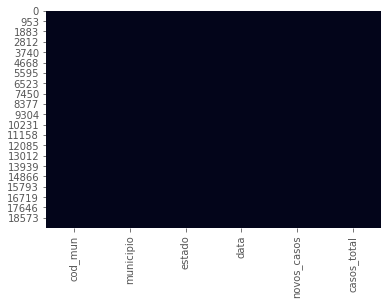

In [10]:
#gráfico heatmap para identificação do padrão de distribuição dos valores nulos no Data Frame
sns.heatmap(df_covid_19_br.isnull(), cbar=False); 

In [11]:
df_covid_19_br.isnull().sum()

cod_mun        0
municipio      0
estado         0
data           0
novos_casos    0
casos_total    0
dtype: int64

### Geração do Data Frame com datas de primeiros casos por município df_data_primeiro_caso*

In [12]:
dic_data_inicial = {}
cod_municipios = df_covid_19_br[~filter_len_cod_mun].cod_mun.unique()
for codigo in cod_municipios:
    data_inicial = df_covid_19_br[df_covid_19_br.cod_mun == codigo]['data'].min()
    dic_data_inicial[codigo] = data_inicial
df_data_primeiro_caso = pd.DataFrame(data=dic_data_inicial.values(), index=dic_data_inicial.keys(), columns = ['data_primeiro_caso'])
df_data_primeiro_caso

,data_primeiro_caso
3550308,2020-02-25
3300407,2020-03-05
2910800,2020-03-06
3304557,2020-03-06
5300108,2020-03-07
...,...
2616209,2020-04-17
3124203,2020-04-18
3144508,2020-04-18
3160702,2020-04-18


## Geração do Shapefile com os dados de CoronaVirus

Nesta seção, são preparados os dados para análise via arquivos shapefile e geodata frames.

Dessa forma, são realizadas:


* Geração do data frame de casos de COVID-19 compatível com formatos para geoprocessamento
    * definição da função preparing_shape_data()
    * uso da função preparing_shape_data() para, a partir do df_covid_19_br, gerar o Data Frame df_covid_19_br_to_shape
* Geração do geodata frame gdf_municipios_br por importação de shapefile
    * 
    * identificação da estrutura (linhas e colunas) do Data Frame df_covid_19_br_to_shape
    * adequação de nomes e tipos de colunas
    * junção das colunas de datas com casos registrados ao geo data frame gdf_municipios_br
    * checagem de consistência, por meio de observação dos municípios com maior número de casos em 30 de março de 2020
    * plotagem de figura com a localizaçãod dos municípios com casos em 16 de abril de 2020)
    * salvamento de arquivo shapefile com os dados de casos importados


* observação preliminar do geodataframe
    * identificação da estrutura de linhas, colunas e seus tipos

### Geração do data frame de casos de COVID-19 compatível com formatos para geoprocessamento

Arquivos de geoprocessamento, como shapefiles, apresentam os diferentes territórios nas linhas e seus atributos nas colunas. Por essa razão, a partir do Data Frame df_covid_19_br, adiante é gerado o Data Frame df_covid_19_br_to_shape, conforme a função preparing_shape_data

**função preparing_shape_data**

In [13]:
def preparing_shape_data(df):
    
    
    # retira os casos do estado que não estão associados a municipios
    filter_len_cod_mun = df.cod_mun.astype('str').str.len() == 2 #filtro de cod_mun de apenas dois caracteres
    df = df[~filter_len_cod_mun] # Retira do Data Frame df as linhas em que cod_mun tem apenas dois caracteres 
    
    # pivoteia o df, com cod_mun na linha, datas nas colunas e casos totais como valores
    df = df[['cod_mun',
              'data',
              'casos_total']].pivot_table(index='cod_mun', columns='data', values='casos_total')
    
    # corrige o nome das colunas
    list_new_column_names = []
    for old_name in df.columns:
        new_name = 'dia' + old_name.split('-')[2]+ old_name.split('-')[1]
        list_new_column_names.append(new_name)
    df.columns = list_new_column_names
    
    
    
    #list_new_column_names = []
    #for old_column_name in df.columns:
    #    new_name = 'dia' + old_column_name.split('-')[1] + old_column_name.split('-')[0]
    #    list_new_column_names.append(new_name)
    #df.columns = list_new_column_names
    
    # insere 0 nos casos em que o valores são nulos
    df.fillna(0, inplace=True)
    
    # transforma os dados em integers
    
    df = df.astype('int32')
    
    
    return df

**df_covid_19_br_to_shape com municípios nas linhas e datas com registros de casos nas colunas**

In [14]:
# Gera o Data Frame com os dados de COVID no formato adequado para importação em Geo Data Frame
df_covid_19_br_to_shape = preparing_shape_data(df_covid_19_br)

# visualização do Data Frame com os dados para importação em Geo Data Frame
df_covid_19_br_to_shape

,dia2502,dia2602,dia2702,dia2802,dia2902,dia0103,dia0203,dia0303,dia0403,dia0503,...,dia0904,dia1004,dia1104,dia1204,dia1304,dia1404,dia1504,dia1604,dia1704,dia1804
cod_mun,,,,,,,,,,,,,,,,,,,,,
1100023,0,0,0,0,0,0,0,0,0,0,...,0,2,2,7,7,7,7,16,20,20
1100114,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1100122,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,2,3,6,6,6
1100155,0,0,0,0,0,0,0,0,0,0,...,1,1,1,2,2,6,6,6,6,6
1100205,0,0,0,0,0,0,0,0,0,0,...,23,23,25,27,27,49,52,58,71,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5221403,0,0,0,0,0,0,0,0,0,0,...,2,2,3,3,3,4,5,5,5,5
5221601,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5221858,0,0,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6


### Geração e adequação do Geodata Frame dos municípios brasileiros

Geodata Frame é a estrutura de dados do pacote Geopandas, que permite a plotagem de mapas temáticos, a partir de geometrias cartográficas armazenas como uma de suas colunas (geometry series) e dos atributos armazenados em suas demais colunas. Assim, adiante é criado o Geodata Frame gdf_municipios_br, a partir da malha de municípios do IBGE, com sua posterior adequação, junção com os dados de covid-19 e exportação para formato shapefile.

**gdf_municipios_br a partir da shapefile dos municípios no Brasil**

In [15]:
# Cria o Geo Data Frame com base na shapefile de todos os municipios do Brasil
gdf_municipios_br = gpd.read_file('BRMUE250GC_SIR.shp', encoding='utf-8')
gdf_municipios_br

,NM_MUNICIP,CD_GEOCMU,geometry
0,CACHOEIRA DO PIRIÁ,1501956,"POLYGON ((-46.31955 -1.75518, -46.31990 -1.755..."
1,SÃO JOSÉ DOS BASÍLIOS,2111250,"POLYGON ((-44.63409 -5.03498, -44.63407 -5.034..."
2,APARECIDA DO RIO DOCE,5201454,"POLYGON ((-51.14230 -18.29672, -51.14236 -18.2..."
3,ARENÓPOLIS,5202353,"POLYGON ((-51.69953 -16.23270, -51.69957 -16.2..."
4,CURUÁ,1502855,"POLYGON ((-55.17193 -1.83331, -55.16647 -1.731..."
...,...,...,...
5567,PARAGUAÇU PAULISTA,3535507,"POLYGON ((-50.69420 -22.39885, -50.69410 -22.3..."
5568,ÁGUA LIMPA,5200209,"POLYGON ((-48.86197 -17.98972, -48.86111 -17.9..."
5569,SANTA CRUZ DO SUL,4316808,"POLYGON ((-52.46848 -29.70647, -52.46847 -29.7..."
5570,SAUDADES,4217303,"POLYGON ((-53.10221 -26.93414, -53.10236 -26.9..."


**Estrutura de linhas e colunas do Geo Data Frame gdf_municipios_br e seus tipos**

In [16]:
# Verifica a estrutura do Geo Data Frame
gdf_municipios_br.info() 

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
NM_MUNICIP    5572 non-null object
CD_GEOCMU     5572 non-null object
geometry      5572 non-null geometry
dtypes: geometry(1), object(2)
memory usage: 130.7+ KB


**Adequações de nomes e dos tipos de colunas**

In [17]:
# Renomeia as colunas do Geo Data Frame
gdf_municipios_br.columns = ['municipio', 'cod_mun', 'geometry']

# Altera o tipo da coluna cod_mun no Geo Data Frame para integer
gdf_municipios_br.cod_mun  = pd.to_numeric(gdf_municipios_br.cod_mun, downcast='integer')

**junção das colunas de datas com casos registrados ao geo data frame gdf_municipios_br**

In [18]:
# Expande o Data Frame df_covid_19_br_to_shape para que tenha os mesmos indexes encontrados no Geo Data Frame

df_covid_19_br_to_shape = df_covid_19_br_to_shape.reindex(gdf_municipios_br.cod_mun.values)

# Faz a junção entre Geo Data Frame e o Data Frame 

gdf_municipios_br = gdf_municipios_br.merge(df_covid_19_br_to_shape, on='cod_mun')

#  inserção de 0 nos valores nulos alocados nos municípios que não têm casos em uma determinada data
gdf_municipios_br.iloc[:, 3:] = gdf_municipios_br.iloc[:, 3:].fillna(0)

**Observação dos municípios com maior número de casos em 30 de março de 2020**

In [19]:
gdf_municipios_br.nlargest(n=10, columns='dia3003')

,municipio,cod_mun,geometry,dia2502,dia2602,dia2702,dia2802,dia2902,dia0103,dia0203,...,dia0904,dia1004,dia1104,dia1204,dia1304,dia1404,dia1504,dia1604,dia1704,dia1804
2537,SÃO PAULO,3550308,"POLYGON ((-46.46934 -23.48106, -46.46885 -23.4...",1.00,1.00,1.00,2.00,2.00,2.00,2.00,...,5477.00,5982.00,6131.00,6352.00,6418.00,6705.00,7764.00,7908.00,8744.00,8744.00
1067,RIO DE JANEIRO,3304557,"MULTIPOLYGON (((-43.70288 -22.98523, -43.70286...",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1633.00,1808.00,1905.00,1996.00,2322.00,2393.00,2519.00,2659.00,2946.00,2946.00
440,FORTALEZA,2304400,"POLYGON ((-38.56771 -3.84953, -38.57672 -3.845...",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1283.00,1366.00,1457.00,1529.00,1686.00,1794.00,1946.00,2041.00,2300.00,2300.00
2557,BRASÍLIA,5300108,"POLYGON ((-47.81455 -16.04995, -47.81478 -16.0...",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,527.00,556.00,592.00,618.00,641.00,651.00,688.00,727.00,756.00,764.00
3566,BELO HORIZONTE,3106200,"POLYGON ((-43.92060 -19.80202, -43.92021 -19.8...",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,310.00,330.00,338.00,355.00,357.00,373.00,380.00,390.00,406.00,420.00
1072,PORTO ALEGRE,4314902,"MULTIPOLYGON (((-51.28678 -30.12193, -51.28710...",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,303.00,303.00,311.00,314.00,315.00,327.00,350.00,361.00,369.00,369.00
2346,MANAUS,1302603,"POLYGON ((-59.92021 -2.61052, -59.91470 -2.616...",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,800.00,863.00,932.00,1053.00,1106.00,1295.00,1350.00,1459.00,1531.00,1531.00
3087,SALVADOR,2927408,"POLYGON ((-38.39181 -12.84328, -38.39180 -12.8...",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,314.00,343.00,355.00,364.00,390.00,427.00,521.00,572.00,643.00,643.00
4876,CURITIBA,4106902,"POLYGON ((-49.24591 -25.34942, -49.24536 -25.3...",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,237.00,251.00,279.00,302.00,299.00,302.00,306.00,320.00,335.00,335.00
1713,RECIFE,2611606,"POLYGON ((-34.91029 -7.95375, -34.91285 -7.969...",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,340.00,413.00,486.00,557.00,672.00,733.00,857.00,958.00,1136.00,1136.00


**figura com a localizaçãod dos municípios com casos em 16 de abril de 2020)**

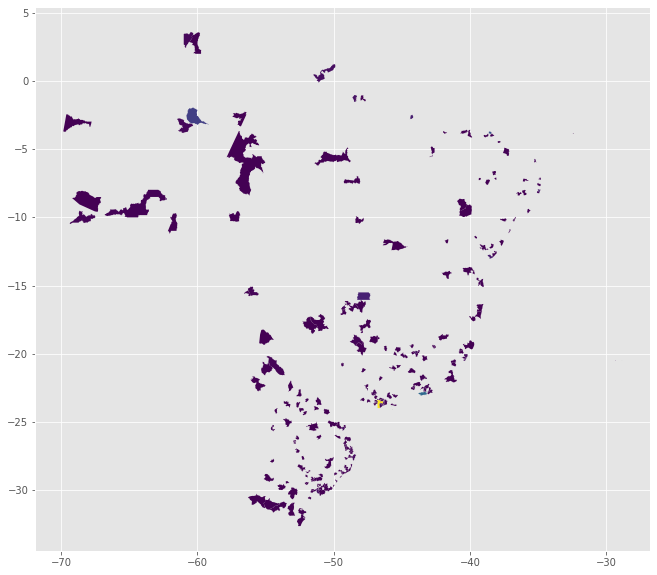

In [20]:
gdf_municipios_br[gdf_municipios_br['dia2703'] != 0].plot(column='dia1604', figsize=(15, 10))

**Salvamento de arquivo shapefile com os dados de casos importados**

In [21]:
gdf_municipios_br.to_file(driver = 'ESRI Shapefile', filename = 'BRMUE250GC_SIR_alterado.shp')

## Importação de Base sobre Fatores Geográficos

Nesta seção, são preparados os dados com fatores geográficos (população, PIB, PIB per capita, graus de competitividade de turismo, índice de intermediação, índice de proximidade, etc).



Dessa forma, são realizadas:


* geração do data frame df_fatores_geograficos, 
    * estatística descritiva dos fatores geográficos
    * estabelecimento de municípios como indexação
    * junção com colunas de dados sobre covid-19
    * retirada de nulos
    * inserção de colunas de contagem de dias para o primeiro caso desde 24 de fevereiro (dia anteiror ao primeiro caso registrado)
    * exportação de arquivo

**Geração do Data Frame df_fatores_geograficos, observação de sua estrutura de dados**

In [22]:
df_fatores_geograficos = pd.read_csv('0_base_compilada_de_fatores_geograficos.csv', delimiter=';', encoding='utf-8')
df_fatores_geograficos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 26 columns):
cod_mun                   5570 non-null int64
UF                        5570 non-null object
Município                 5570 non-null object
pop2019                   5570 non-null int64
pib2017milreais           5570 non-null int64
export_fob_2019           5570 non-null int64
import_fob_2019           5570 non-null int64
pip_per_capita17          5570 non-null int64
hierarquia_urbana07       5570 non-null object
hierarquia                5570 non-null int64
voos_dom                  5570 non-null int64
voos_int                  5570 non-null int64
voos_dom_19               5570 non-null int64
voos_int_19               5570 non-null int64
indice_proximidade        5570 non-null object
indice_intermediacao      5570 non-null object
turismo                   5570 non-null int64
classe_pop                5570 non-null object
classe_pib                5570 non-null object
classe_capit

**estatística descritiva das colunas numéricas do df_fatores_geograficos**

In [23]:
df_fatores_geograficos.describe()

,cod_mun,pop2019,pib2017milreais,export_fob_2019,import_fob_2019,pip_per_capita17,hierarquia,voos_dom,voos_int,voos_dom_19,voos_int_19,turismo
count,5570.00,5570.00,5570.00,5570.00,5570.00,5570.00,5570.00,5570.00,5570.00,5570.00,5570.00,5570.00
mean,3253590.77,37728.39,1181924.41,40408377.94,31839822.75,21990.75,1.72,12.08,1.00,18361.41,2152.64,1.11
std,984910.34,221458.06,11621728.62,309921003.98,312262568.40,20946.33,1.92,254.33,40.66,415366.41,101765.15,1.31
min,1100015.00,781.00,12993.00,0.00,0.00,3290.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,2512125.75,5446.50,79101.50,0.00,0.00,9490.00,1.00,0.00,0.00,0.00,0.00,0.00
50%,3146280.00,11631.00,176621.50,0.00,0.00,16600.00,1.00,0.00,0.00,0.00,0.00,0.00
75%,4119189.50,25490.50,470221.25,1264063.75,164892.25,27050.00,1.00,0.00,0.00,0.00,0.00,2.00
max,5300108.00,12252023.00,699288352.00,11309835507.00,10129708024.00,344850.00,11.00,15172.00,2791.00,25680039.00,7240863.00,5.00


**Adequações do data frame df_fatores_geograficos**

In [24]:
# estabelece os códigos dos municípios como o index
df_fatores_geograficos.set_index('cod_mun', inplace=True)

# faz a junção das colunas de contaminação por datas, em df_covid_19_to_shape, ao df_fatores_geograficos 
df_fatores_geograficos = df_fatores_geograficos.join(df_covid_19_br_to_shape, on='cod_mun')

# insere valores 0 para as colunas de datas de contaminação nos municípios sem casos
df_fatores_geograficos.iloc[:, 10:] = df_fatores_geograficos.iloc[:, 10:].fillna(0)


# faz a junção da coluna data_primeiro_caso, em df_data_primeiro_caso, ao df_fatores_geograficos 
df_fatores_geograficos = df_fatores_geograficos.join(df_data_primeiro_caso, on='cod_mun')

# transforma a coluna data_primeiro_caso em tip datetime
df_fatores_geograficos.data_primeiro_caso = pd.to_datetime(df_fatores_geograficos.data_primeiro_caso)


# inserção da coluna dias_contaminacao_referencia, que calcula quantos dias para a primeira contaminação em cada município a partir de 24 de março
# no código anterior eu usava df_fatores_geograficos['data_padrao'] = pd.to_datetime('2020-02-24'), mas parece funcionar com o código abaixo
df_fatores_geograficos['dias_contaminação_referencia'] = df_fatores_geograficos['data_primeiro_caso'].sub(pd.to_datetime('2020-02-24'), axis=0)

# transforma a variação de dias em integers
df_fatores_geograficos['dias_contaminação_referencia'] = df_fatores_geograficos['dias_contaminação_referencia'] / np.timedelta64(1, 'D')

# apresentação do DataFrame alterado
df_fatores_geograficos

,UF,Município,pop2019,pib2017milreais,export_fob_2019,import_fob_2019,pip_per_capita17,hierarquia_urbana07,hierarquia,voos_dom,...,dia1104,dia1204,dia1304,dia1404,dia1504,dia1604,dia1704,dia1804,data_primeiro_caso,dias_contaminação_referencia
cod_mun,,,,,,,,,,,,,,,,,,,,,
1100015,RO,Alta Floresta D'Oeste,22945,498864,198695,13294,19610,Centro Local,1,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaT,nan
1100023,RO,Ariquemes,107863,2296074,38002769,738809,21390,Centro Subregional B,4,0,...,2.00,7.00,7.00,7.00,7.00,16.00,20.00,20.00,2020-04-10,46.00
1100031,RO,Cabixi,5312,138894,137660,0,22320,Centro Local,1,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaT,nan
1100049,RO,Cacoal,85359,2127523,20514957,53854,24040,Centro Subregional B,4,25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaT,nan
1100056,RO,Cerejeiras,16323,448524,97838806,59259,25010,Centro de Zona B,2,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaT,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5222005,GO,Vianópolis,13863,395787,0,0,28940,Centro Local,1,0,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2020-04-07,43.00
5222054,GO,Vicentinópolis,8743,350765,6518444,0,41770,Centro Local,1,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaT,nan
5222203,GO,Vila Boa,6171,137500,0,0,23990,Centro Local,1,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaT,nan


**exportação de arquivos**

In [25]:
df_fatores_geograficos.to_csv('fatores_total.csv', sep=';', decimal=',', encoding='utf-16')

In [26]:
df_covid_19_br.to_csv('base_covid_atualizada.csv', decimal=',', sep=';', encoding='utf-16')